In [2]:
import random
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm

In [4]:
# Seed

In [3]:
seed = 69

print("Random seed", seed)
random.seed(seed)
torch.manual_seed(seed)

Random seed 69


In [5]:
# compute and model parameters

<function tqdm.tqdm_notebook(*args, **kwargs)>

In [9]:
num_workers = 6

batch_size = 128
image_size = 64
nc = 3 # image chanel
nz = 100 # z latent, generator input
ngf = 64 # feature maps number in generator
ndf = 64 # feature maps number in discriminator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device", device)

Device cpu


In [10]:
# define generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # num of z input
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # second layer
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # third layer
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # fourth layer
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # last layer
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.model(input)

In [11]:
netG = Generator().to(device)


In [12]:
# Discriminator

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False), # first layer
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False), # second layer
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False), # third layer
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False), # fourth layer
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False), # last layer
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input)
    
netD = Discriminator().to(device)


In [21]:
path = "data/"
dataset = datasets.ImageFolder(root=path, 
                            transform=transforms.Compose([
                                transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),
                                                    (0.5, 0.5, 0.5))
                            ]))

In [22]:
dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=True, num_workers=num_workers)

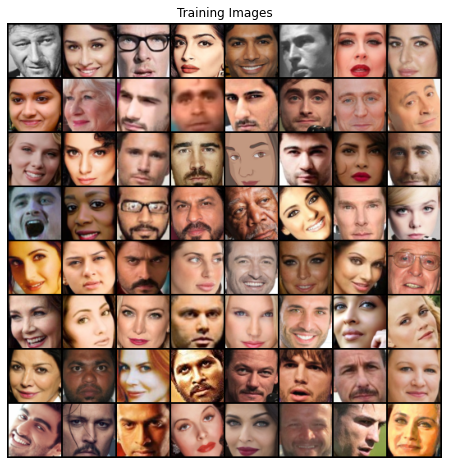

In [23]:
images, _ = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(images.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [33]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1
fake_label = 0

lr = 0.0002
beta1 = 0.5

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

num_epochs = 100
img_list = []
G_losses = []
D_losses = []

iters = 0
step = 200

In [34]:
print("Starting Training Loop...")

for epoch in tqdm(range(num_epochs)):
    for i, data in (enumerate(dataloader)):
        netD.zero_grad()
        images = data[0].to(device)
        b_size = images.size(0)
        labels = torch.full((b_size,), real_label, device=device)
        real_out = netD(images).view(-1)
        loss_real = criterion(real_out.float(), labels.float())
        loss_real.backward()
        dx = real_out.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)

        fake = netG(noise)
        labels.fill_(fake_label)
        fake_out = netD(fake.detach()).view(-1)
        loss_fake = criterion(fake_out.float(), labels.float())
        loss_fake.backward()
        dz1 = fake_out.mean().item()
        loss_D = loss_real + loss_fake
        optimizerD.step()


        ## Trianing G network
        netG.zero_grad()
        labels.fill_(real_label)
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        fake_image = netG(noise)
        output = netD(fake_image).view(-1)
        loss_G = criterion(output.float(), labels.float())
        loss_G.backward()
        dz2 = output.mean().item()
        optimizerG.step()
        if i % step == 0:
            print('[%d/%d][%d/%d]\tD Loss: %.4f\tG Loss: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(dataloader),
                        loss_D.item(), loss_G.item(), dx, dz1, dz2))
            
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


/tmp/ipykernel_21427/3931458219.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(num_epochs)):


  0%|          | 0/100 [00:00<?, ?it/s]

[0/100][0/19]	D Loss: 1.0434	G Loss: 4.2112	D(x): 0.8876	D(G(z)): 0.5871 / 0.0160
[1/100][0/19]	D Loss: 0.0258	G Loss: 8.7871	D(x): 0.9773	D(G(z)): 0.0003 / 0.0003
